In [1]:
import torch
import sys
sys.path.append('../')
from DataType.ElectricField import ElectricField
from LightSource.Gaussian_beam import Guassian_beam
from Props.ASM_Prop import ASM_prop
from Props.RSC_Prop import RSC_prop
from Components.Thin_Lens import Thin_LensElement
from Components.Aperture import ApertureElement
from Components.QuantizedDOE import SoftGumbelQuantizedDOELayerv3 as SoftGumbelQuantizedDOELayer
from Components.QuantizedDOE import NaiveGumbelQuantizedDOELayer
from Components.QuantizedDOE import PSQuantizedDOELayer
from Components.QuantizedDOE import STEQuantizedDOELayer
from Components.QuantizedDOE import FullPrecisionDOELayer
from Components.QuantizedDOE import FixDOEElement
from utils.Helper_Functions import normalize, DOE_xyz_cordinates_Generator
from utils.units import *
import numpy as np
import scipy.io
import time
import torch.nn as nn

In [2]:
torch.linspace(0, 1, 5+1)

tensor([0.0000, 0.2000, 0.4000, 0.6000, 0.8000, 1.0000])

In [15]:
# Hologram parameters (high-temp resin)
epsilon = 2.66
tand = 0.003
    
input_field_shape = [100, 100]
input_dxy = 1 * mm
doe_shape = [100, 100]
doe_dxy = 1 * mm
    
    
c0 = 2.998e8
f2 = 300e9  # 0.3 THz

wavelengths = c0 / f2
#print("The number of wavelengths: " +  str(wavelengths.shape[0]))

# all parameters of DOE optimization
doe_params = {
    'doe_size': doe_shape,
    'doe_dxy' : doe_dxy,
    'doe_level': 4,
    'look_up_table': None,
    'num_unit': None,
    'height_constraint_max': 1 * mm,
    'tolerance': 30 * um,  
    'material': [epsilon, tand]
}

optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 2.5, # maximum value of tau
    'tau_min': 1.5  # minimum value of tau
}


#optim_params = {
#    'c_s': 400,
#    'tau_max': 3.5,
#    'tau_min': 1.5
#}

torch.Size([1, 1, 345, 454])


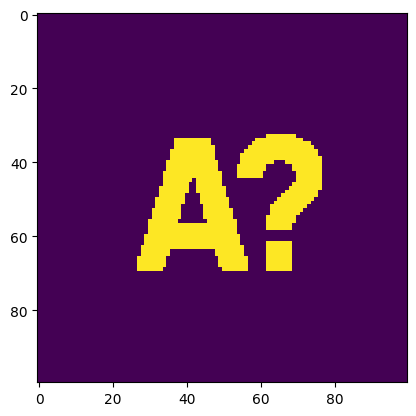

In [11]:
import numpy as np
from PIL import Image
from utils.Helper_Functions import normalize
import matplotlib.pyplot as plt
import torch.nn.functional as F
# choose the recon amp 
im = np.array(Image.open('./data/Aalto-logo.png').convert('L'))
target1 = torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target1 = normalize(target1)
print(target1.shape)
target1 = F.pad(input=target1, pad=(140, 140, 140, 140), mode='constant', value=0)
target1 = nn.functional.interpolate(torch.round(target1), size=[100, 100])
plt.imshow(target1[0,0,:,:])

torch.Size([1, 1, 200, 200])


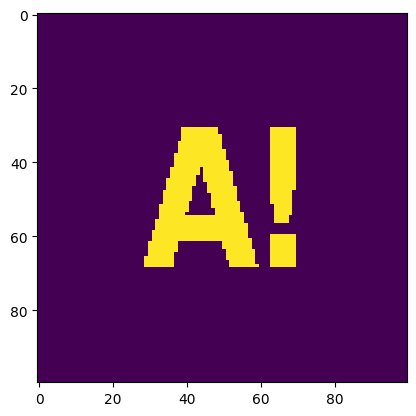

In [12]:
# choose the recon amp 
im = np.array(Image.open('./data/Aalto-logo2.png').convert('L'))
target2 = torch.tensor(im, dtype=torch.float).unsqueeze(0).unsqueeze(0)
target2 = normalize(target2)
print(target2.shape)
target2 = F.pad(input=target2, pad=(90, 90, 90, 90), mode='constant', value=0)
target2 = nn.functional.interpolate(torch.round(target2), size=[100, 100])
plt.imshow(target2[0,0,:,:])

# 2. Define the System with SoftGumbelQuantizedDOE 

In [13]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source  = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        #self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
        #                    bandlimit_type='exact', 
        #                    padding_scale=2, 
        #                    bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = SoftGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [14]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [8]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4000, gamma=0.1)
photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    #scheduler.step()
    if itr % 100 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.13338212668895721
The iteration : 100, Loss: 0.06526795774698257
The iteration : 200, Loss: 0.050241582095623016
The iteration : 300, Loss: 0.043751828372478485
The iteration : 400, Loss: 0.040930457413196564
The iteration : 500, Loss: 0.03849378973245621
The iteration : 600, Loss: 0.03596245497465134
The iteration : 700, Loss: 0.03457031399011612
The iteration : 800, Loss: 0.032940253615379333
The iteration : 900, Loss: 0.03211416304111481
The iteration : 1000, Loss: 0.03111514449119568
The iteration : 1100, Loss: 0.030176319181919098
The iteration : 1200, Loss: 0.029838260263204575
The iteration : 1300, Loss: 0.030532335862517357
The iteration : 1400, Loss: 0.02898050844669342
The iteration : 1500, Loss: 0.027712125331163406
The iteration : 1600, Loss: 0.02886553853750229
The iteration : 1700, 

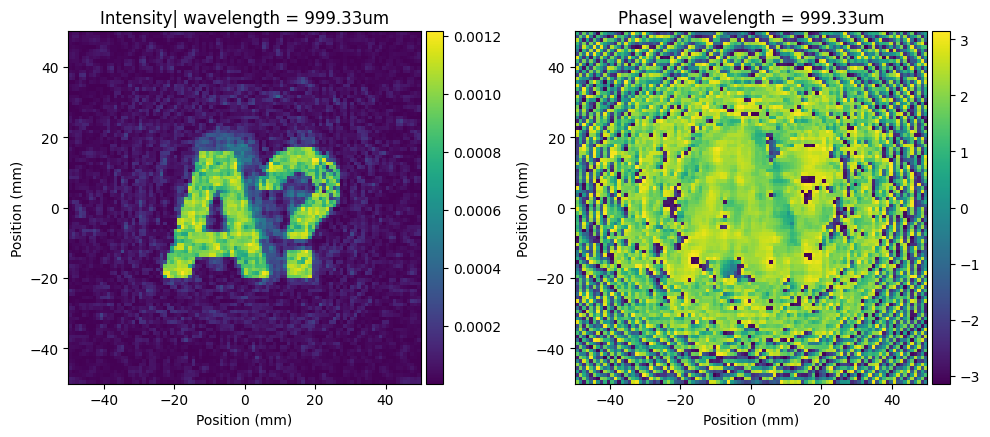

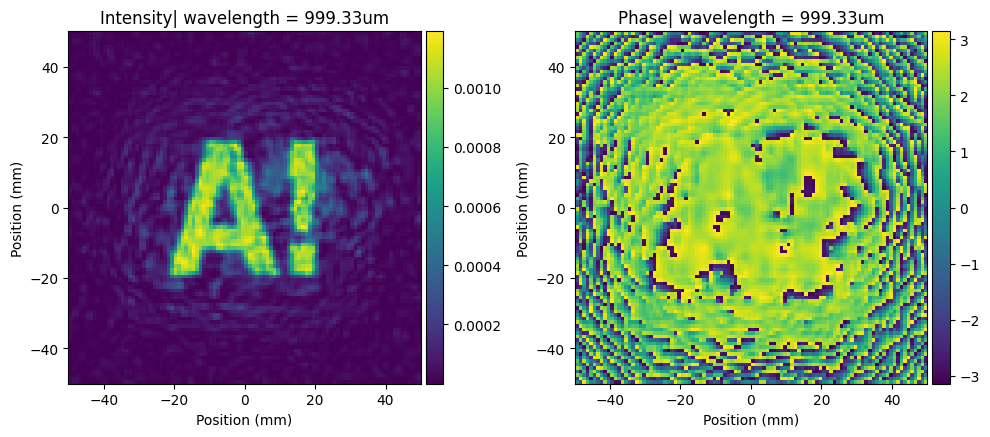

In [9]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

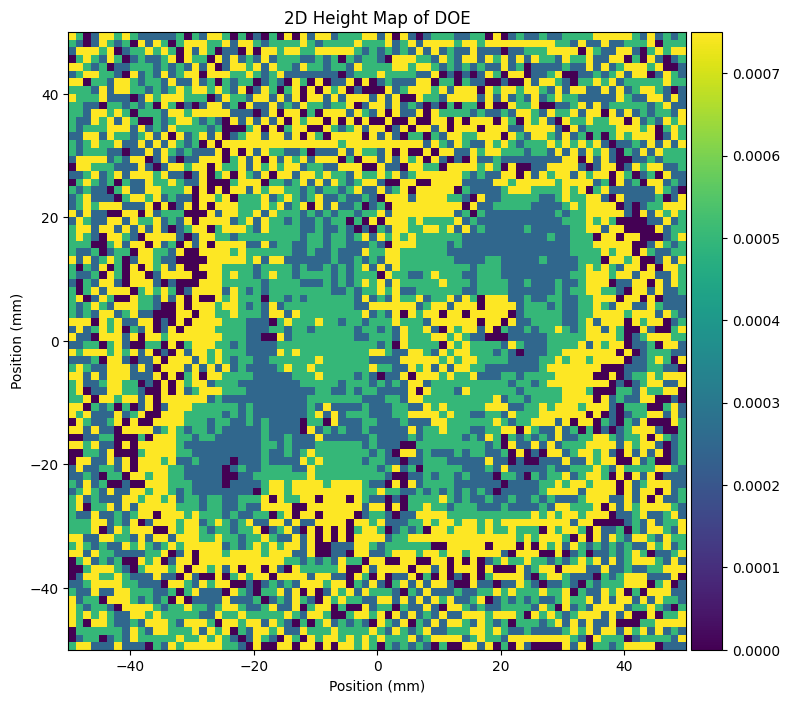

In [10]:
best_setup.doe.visualize(figsize=(8,8), crop_size=[80, 80])

In [11]:
best_loss

tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)

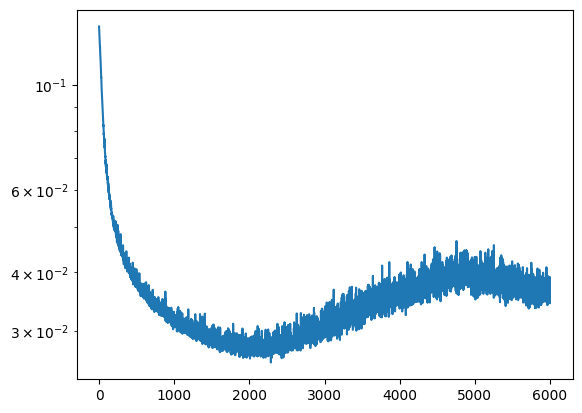

In [12]:
#best_setup.doe.save(crop_size=[80, 80])
np.save('loss_curve_Ours.npy', losses)
plt.plot(losses)
plt.yscale('log')

In [13]:
#data = np.load('height_map_20240815-135819.npy', allow_pickle=True)
#thickness = data.item().get('thickness')
#dxy = data.item().get('dxy')
#plt.imshow(thickness)
#DOE_xyz_cordinates_Generator(thickness, dxy, new_dxy=dxy)

In [14]:
setup.doe.height_map.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500], device='cuda:0',
       grad_fn=<DivBackward0>)

# 3. Define the System with FullPrecisionDOE

In [7]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FullPrecisionDOELayer(self.doe_params)
        

        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [8]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [9]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_setup = setup
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.1607460081577301
The iteration : 200, Loss: 0.07553136348724365
The iteration : 400, Loss: 0.056554537266492844
The iteration : 600, Loss: 0.04896135628223419
The iteration : 800, Loss: 0.043970026075839996
The iteration : 1000, Loss: 0.04139742627739906
The iteration : 1200, Loss: 0.040209174156188965
The iteration : 1400, Loss: 0.03974135220050812
The iteration : 1600, Loss: 0.035559576004743576
The iteration : 1800, Loss: 0.03508345037698746
The iteration : 2000, Loss: 0.033221565186977386
The iteration : 2200, Loss: 0.03218124806880951
The iteration : 2400, Loss: 0.03256921470165253
The iteration : 2600, Loss: 0.03108147531747818
The iteration : 2800, Loss: 0.03055579401552677
The iteration : 3000, Loss: 0.030504118651151657
The iteration : 3200, Loss: 0.029934395104646683
The iteration : 340

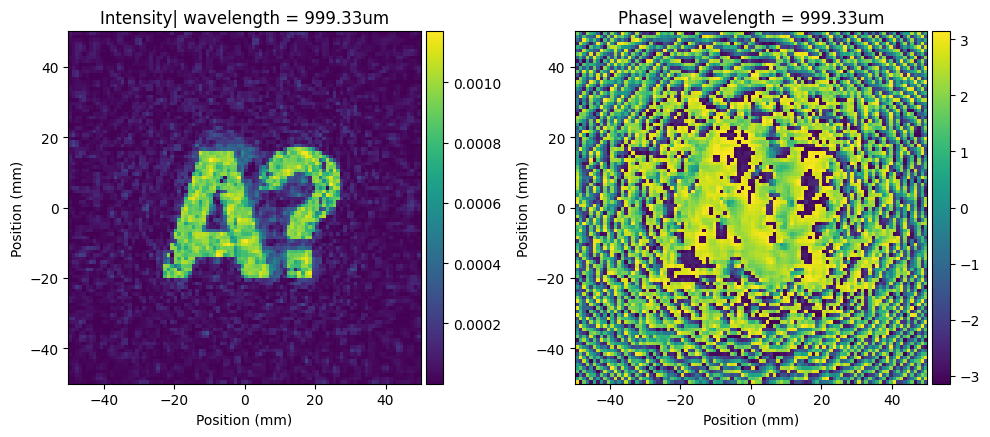

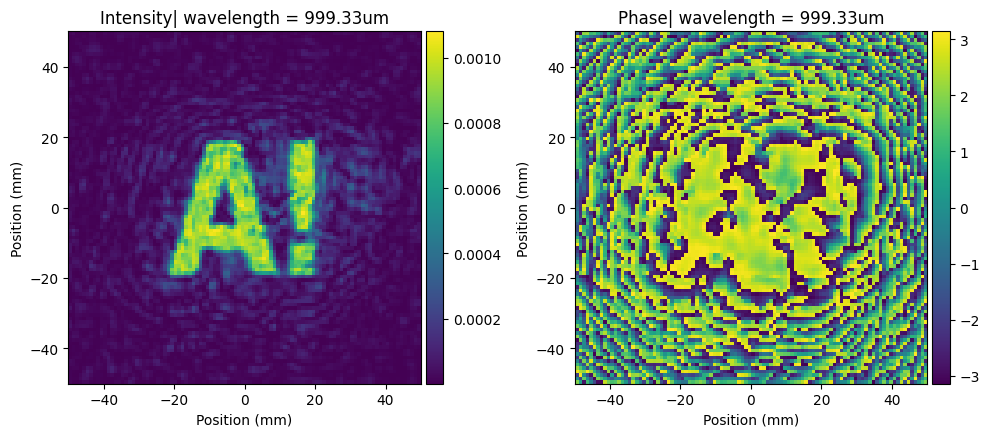

In [10]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

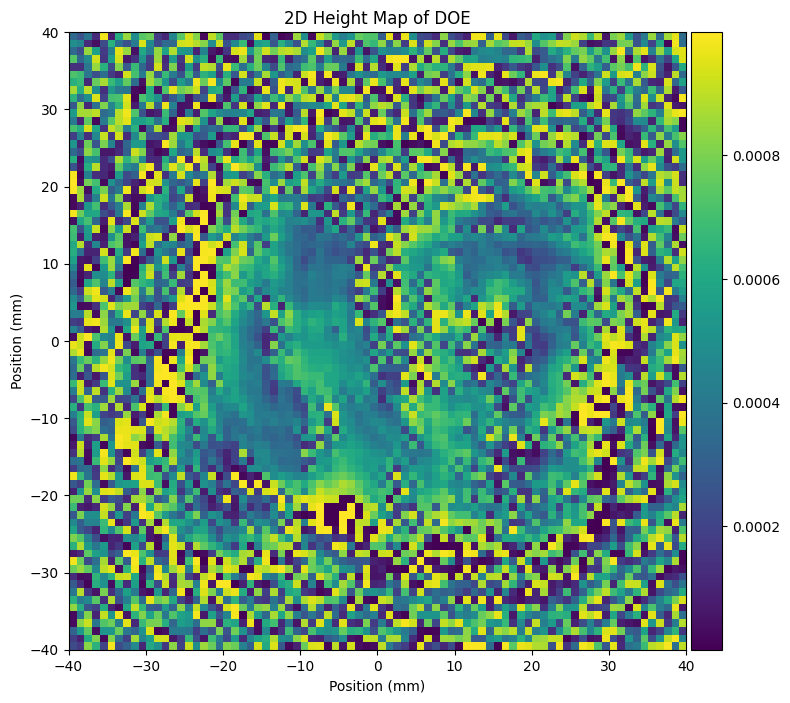

In [11]:
best_setup.doe.visualize(figsize=(8,8), crop_size=[80, 80])

In [12]:
#for p in best_setup.parameters():
#    print(p.data)

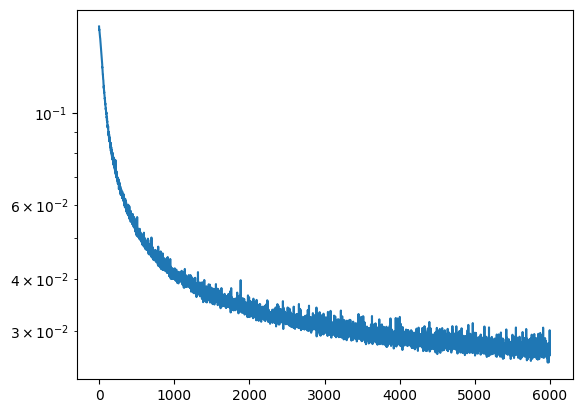

In [13]:
np.save('loss_curve_full.npy', losses)
plt.plot(losses)
plt.yscale('log')

## post quantization process

In [14]:
height_map = best_setup.doe.height_map.cpu()

lut_1 = torch.tensor([0, 1, 2, 3]) * (1 * mm / 4)

lut_2 = torch.tensor([0, 1, 2, 3, 4, 5, 6, 7]) * (1 * mm / 8)

lut_3 = torch.arange(0, 10) * (1 * mm / 10)

lut_4 = torch.arange(0, 20) * (1 * mm / 20)

height_map.unique()

tensor([7.3808e-07, 8.6566e-07, 9.4586e-07,  ..., 9.9881e-04, 9.9884e-04,
        9.9910e-04], grad_fn=<Unique2Backward0>)

In [15]:
def quantization(input, lut):
    idx = torch.argmin(torch.abs(input.unsqueeze(-1) - lut), dim=-1)
    quantized = lut[idx]
    return quantized

In [16]:
quantized = quantization(height_map, lut_1)

quantized.unique() / mm

tensor([0.0000, 0.2500, 0.5000, 0.7500])

In [17]:
class Submm_Setup_test(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 height_map,
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.height_map = height_map
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = FixDOEElement(height_map=self.height_map, tolerance=0*um, material=[epsilon, tand])
        
        
        self.asm_prop3 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        self.asm_prop4 = ASM_prop(z_distance=200 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        #field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [18]:
setup = Submm_Setup_test(input_dxy=input_dxy, 
                      input_field_shape=input_field_shape, 
                      height_map=quantized,
                      optim_params=optim_params,
                      wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [19]:
out_field1, out_field2 = setup.forward(iter_frac=None)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


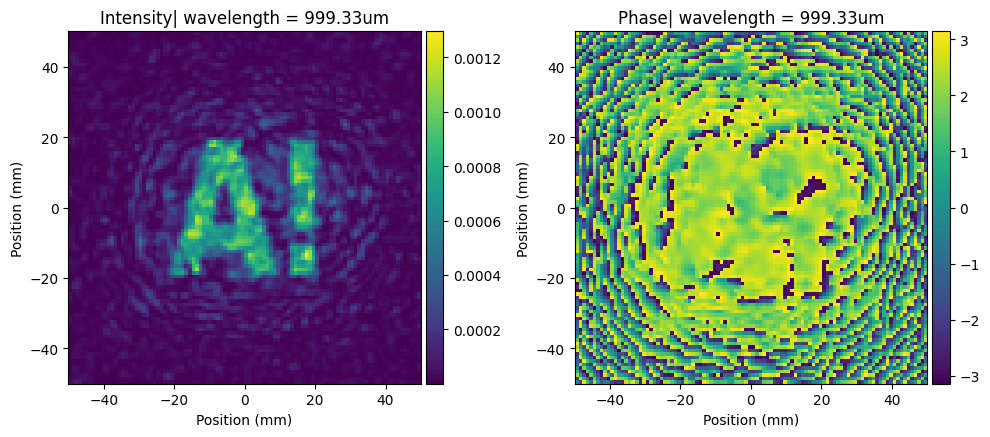

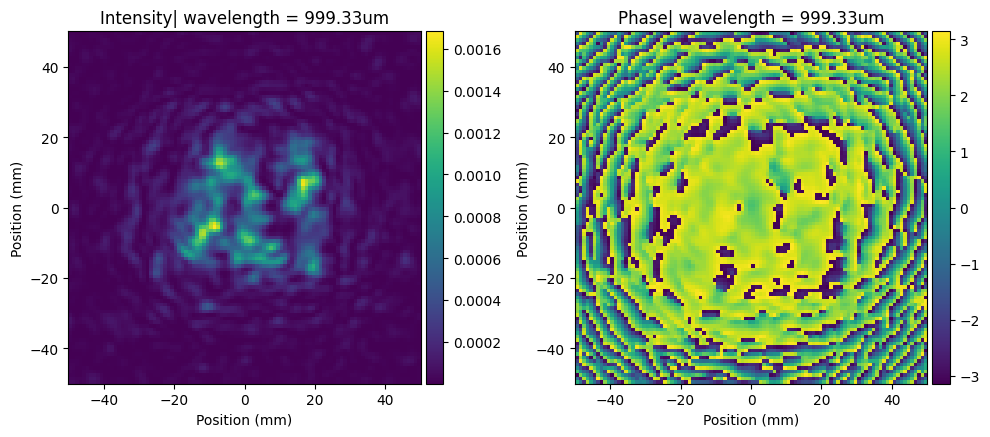

In [19]:
out_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
out_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

In [20]:
out_amp1 = normalize(torch.abs(out_field1.data)**2)
out_amp2 = normalize(torch.abs(out_field2.data)**2)
loss = photometric_loss_fn(out_amp1, target1.cuda()) + photometric_loss_fn(out_amp2, target2.cuda())
loss

tensor(0.0902, device='cuda:0', grad_fn=<AddBackward0>)

In [462]:
best_loss

tensor(0.0218, device='cuda:0', grad_fn=<AddBackward0>)

<Figure size 4800x3000 with 0 Axes>

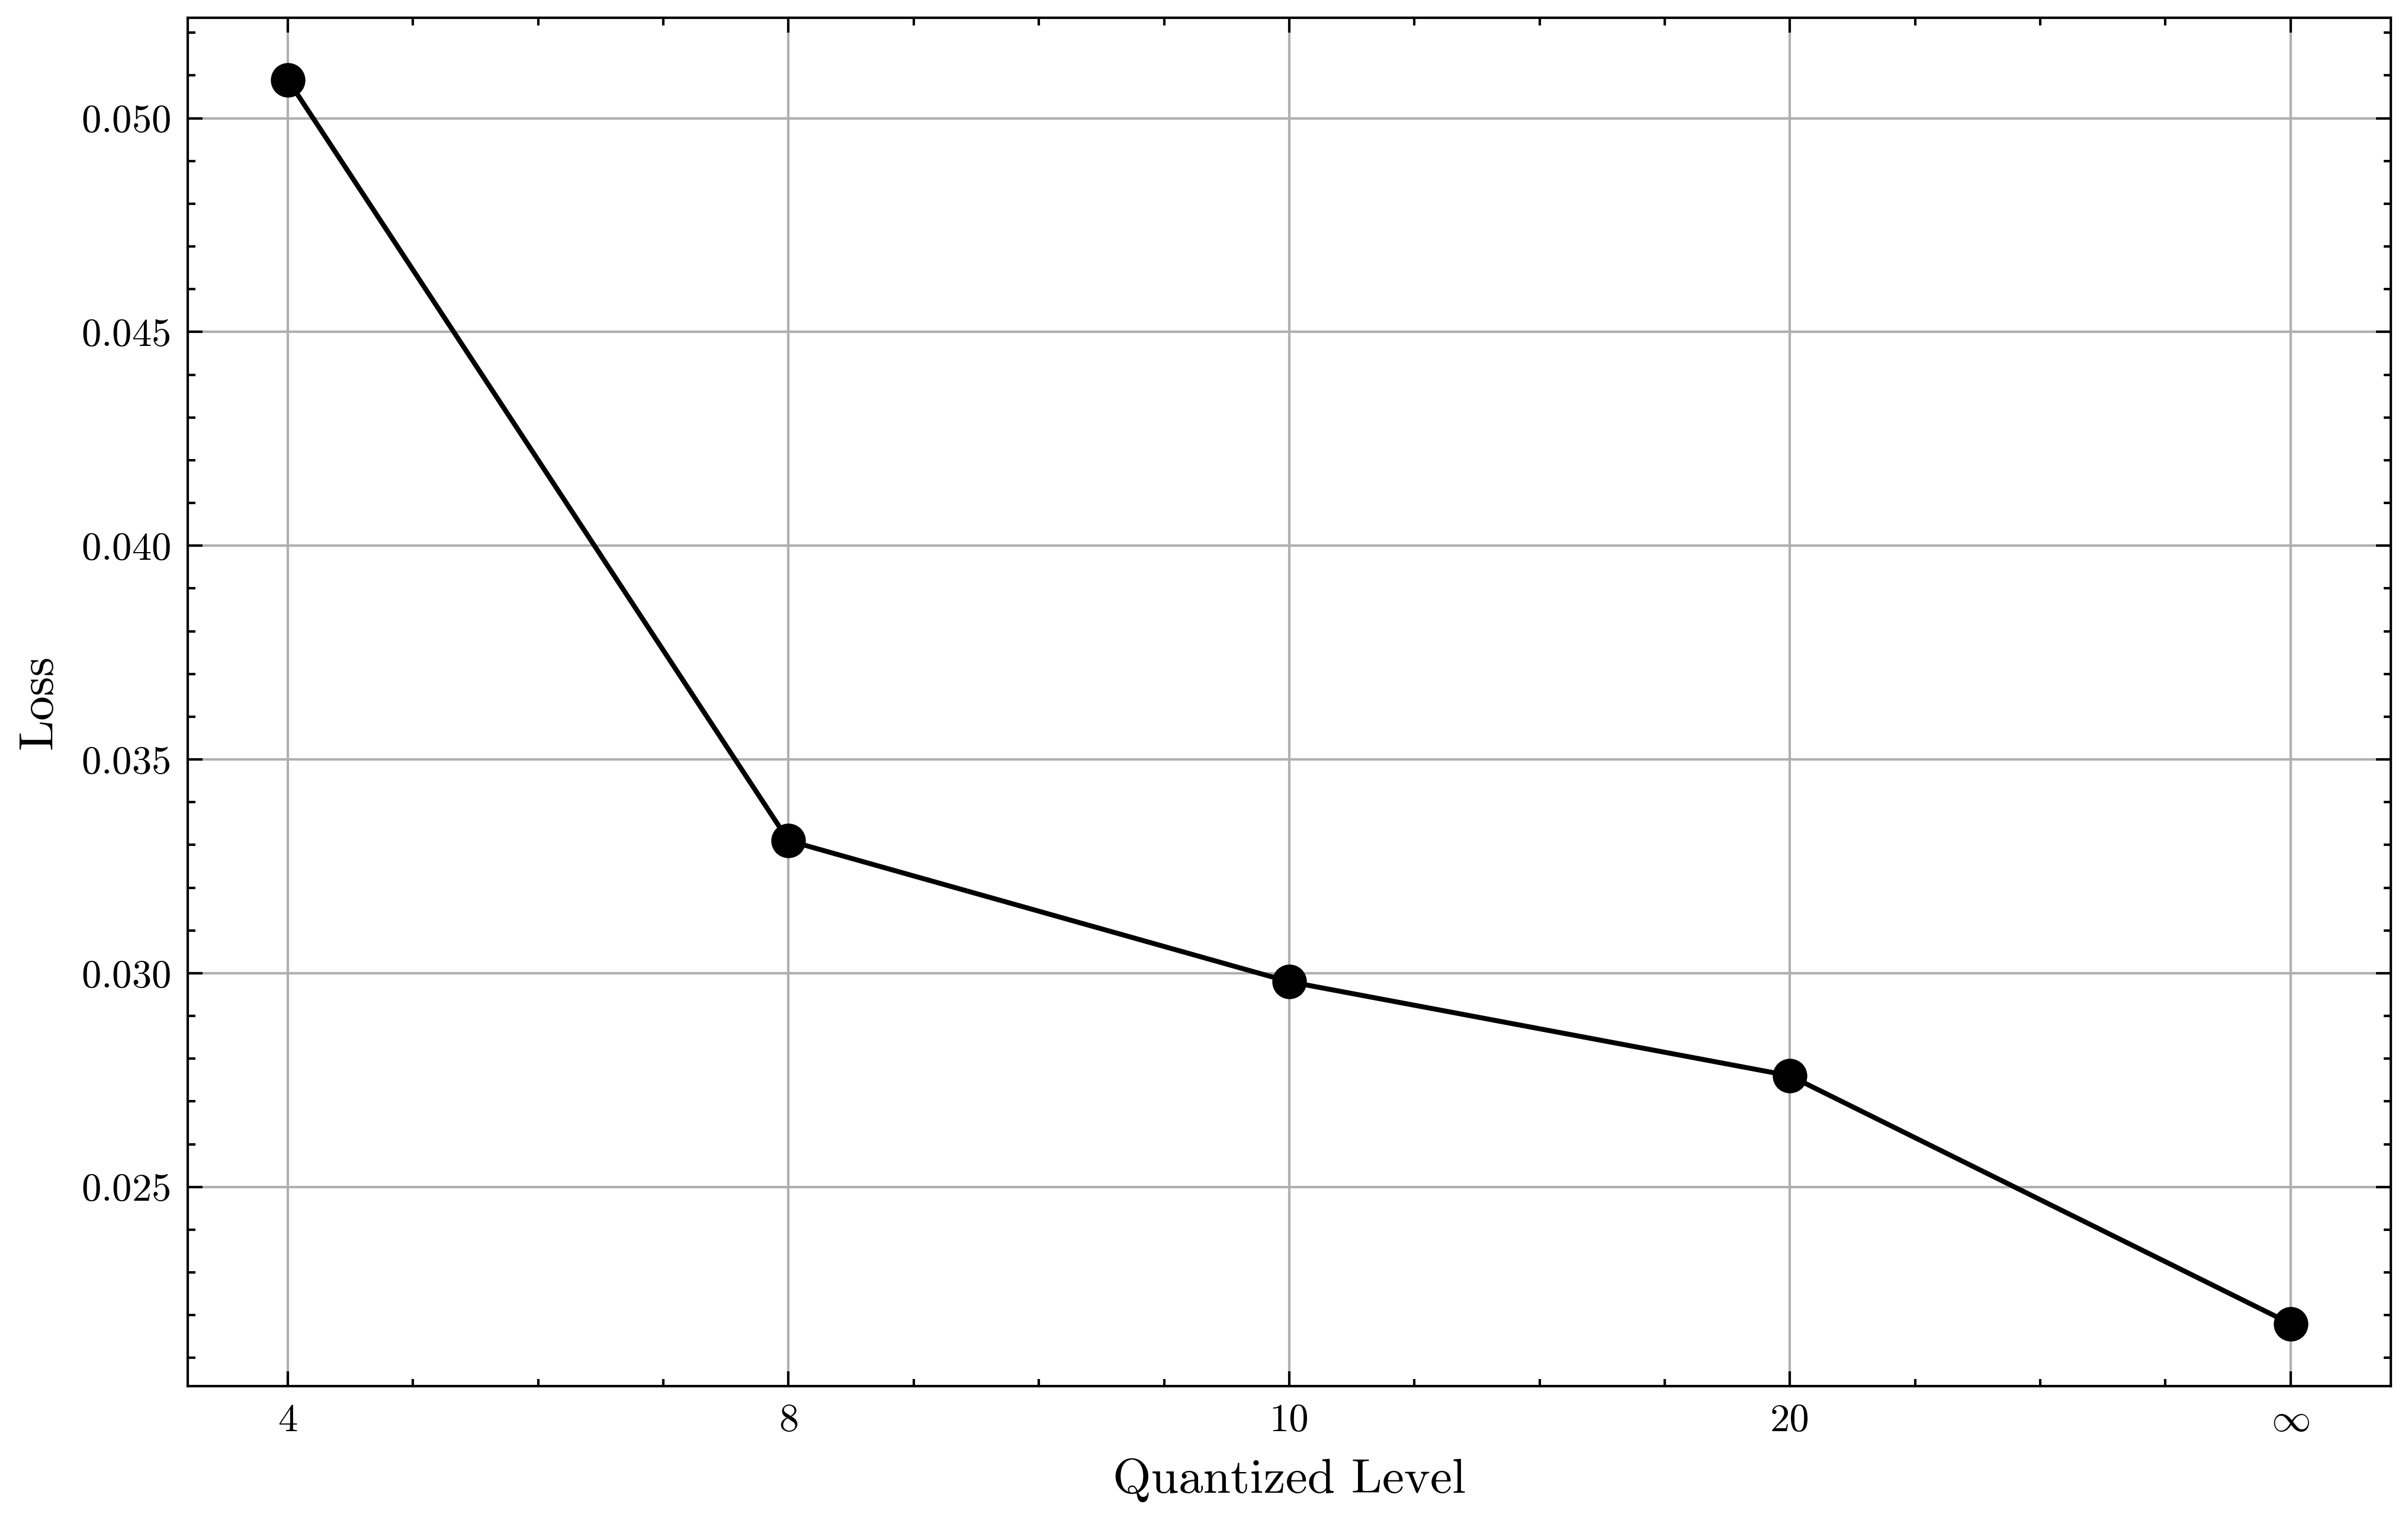

<Figure size 1980x1500 with 0 Axes>

# 4. System with NaiveGumbelQuantizedDOELayer

In [43]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = NaiveGumbelQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [44]:
optim_params = {
    'c_s': 100,   # a number to boost the score (higher more robust to gumbel noise)
    'tau_max': 8.5, # maximum value of tau
    'tau_min': 1.0  # minimum value of tau
}


setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [45]:
max_itrs = 6000 * 5

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 2000 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.15075837075710297
The iteration : 2000, Loss: 0.0961524099111557
The iteration : 4000, Loss: 0.08646640181541443
The iteration : 6000, Loss: 0.07811035960912704
The iteration : 8000, Loss: 0.08325625956058502
The iteration : 10000, Loss: 0.07172907888889313
The iteration : 12000, Loss: 0.08034372329711914
The iteration : 14000, Loss: 0.07042592018842697
The iteration : 16000, Loss: 0.07796431332826614
The iteration : 18000, Loss: 0.06333979964256287
The iteration : 20000, Loss: 0.06890411674976349
The iteration : 22000, Loss: 0.06650584936141968
The iteration : 24000, Loss: 0.06228574365377426
The iteration : 26000, Loss: 0.06078324466943741
The iteration : 28000, Loss: 0.053289659321308136
The iteration : 29999, Loss: 0.05826699733734131


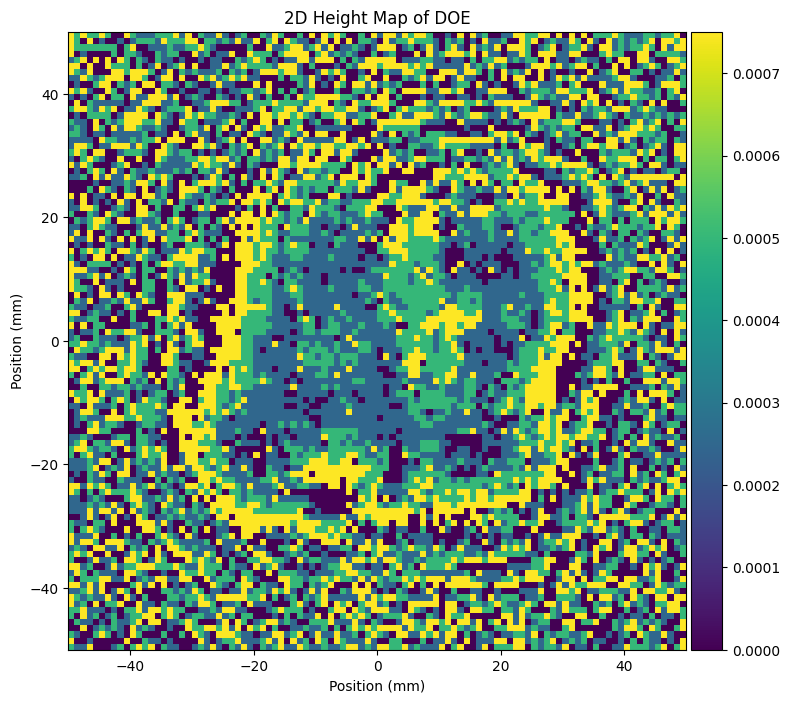

In [46]:
setup.doe.visualize(figsize=(8,8))

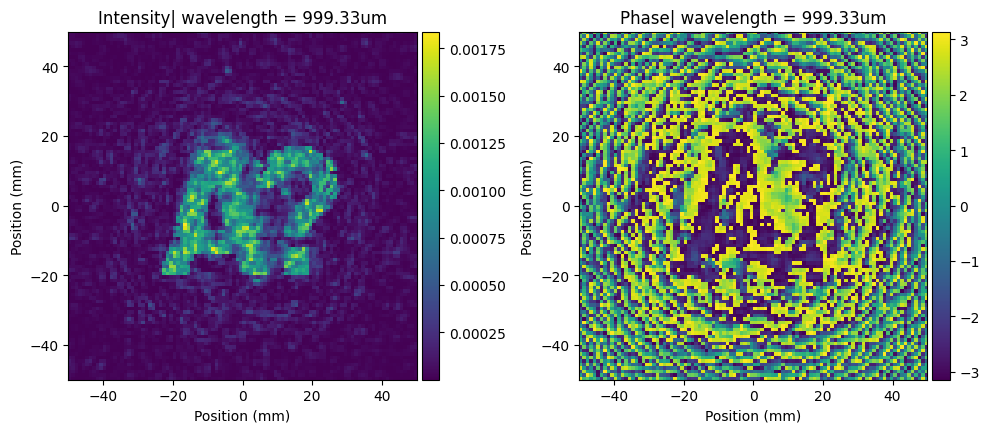

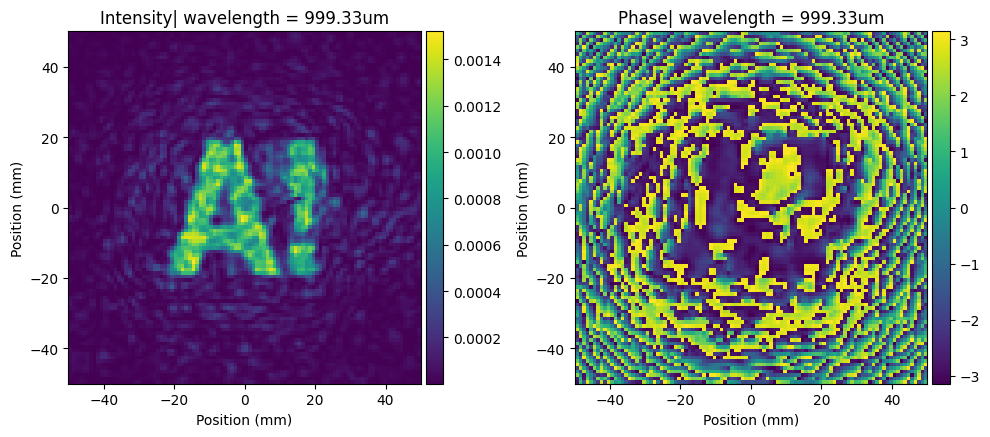

In [47]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

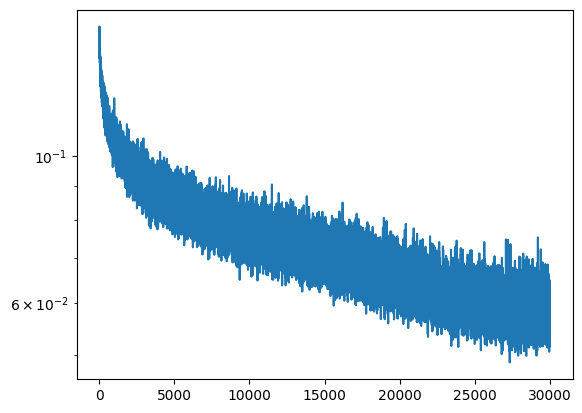

In [48]:
np.save('loss_curve_GQ_more_iteration.npy', losses)
plt.plot(losses)
plt.yscale('log')

# 5. System with PSQuantizedDOELayer

In [41]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = PSQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [42]:
optim_params = {
    'c_s': 300,
    'tau_max': 800,
    'tau_min': 1
}
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [43]:
max_itrs = 6000

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 200 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.1249781996011734
The iteration : 200, Loss: 0.06143040582537651
The iteration : 400, Loss: 0.057553403079509735
The iteration : 600, Loss: 0.05806425213813782
The iteration : 800, Loss: 0.06009071692824364
The iteration : 1000, Loss: 0.05924870818853378
The iteration : 1200, Loss: 0.060030434280633926
The iteration : 1400, Loss: 0.06092747300863266
The iteration : 1600, Loss: 0.060746368020772934
The iteration : 1800, Loss: 0.06121392175555229
The iteration : 2000, Loss: 0.06169750541448593
The iteration : 2200, Loss: 0.06269347667694092
The iteration : 2400, Loss: 0.06228145956993103
The iteration : 2600, Loss: 0.061354368925094604
The iteration : 2800, Loss: 0.06262519955635071
The iteration : 3000, Loss: 0.06263849884271622
The iteration : 3200, Loss: 0.061967577785253525
The iteration : 3400,

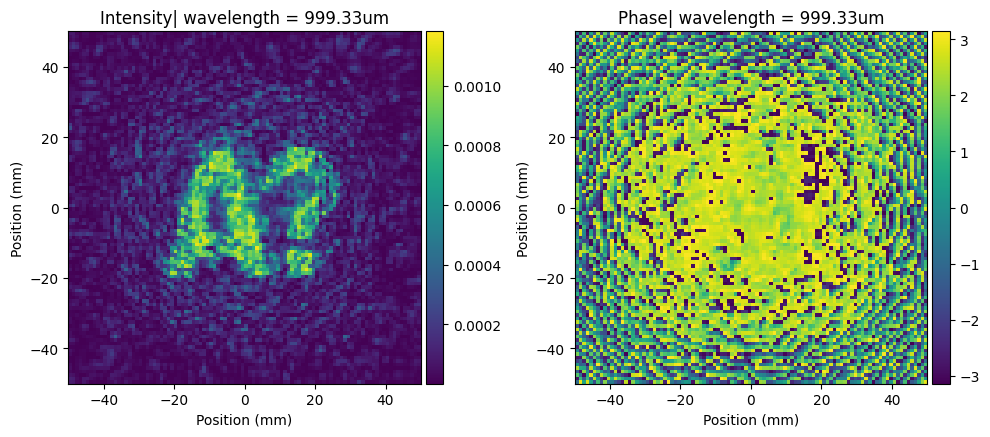

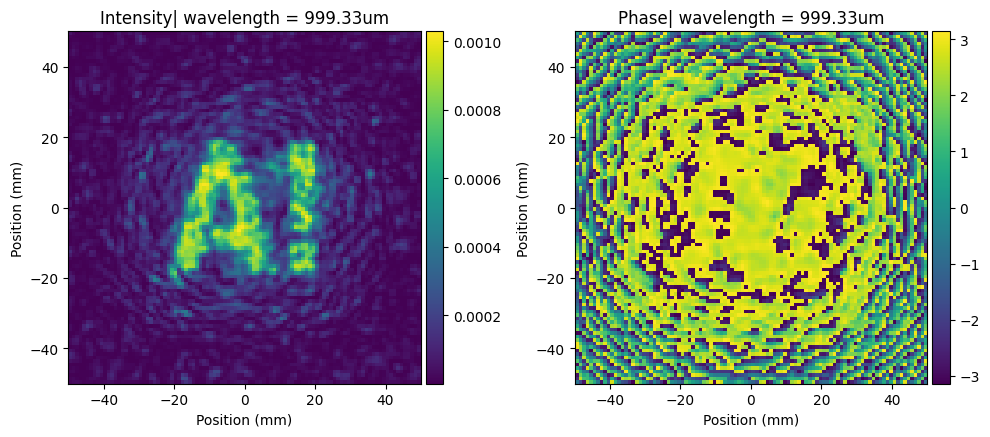

In [44]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

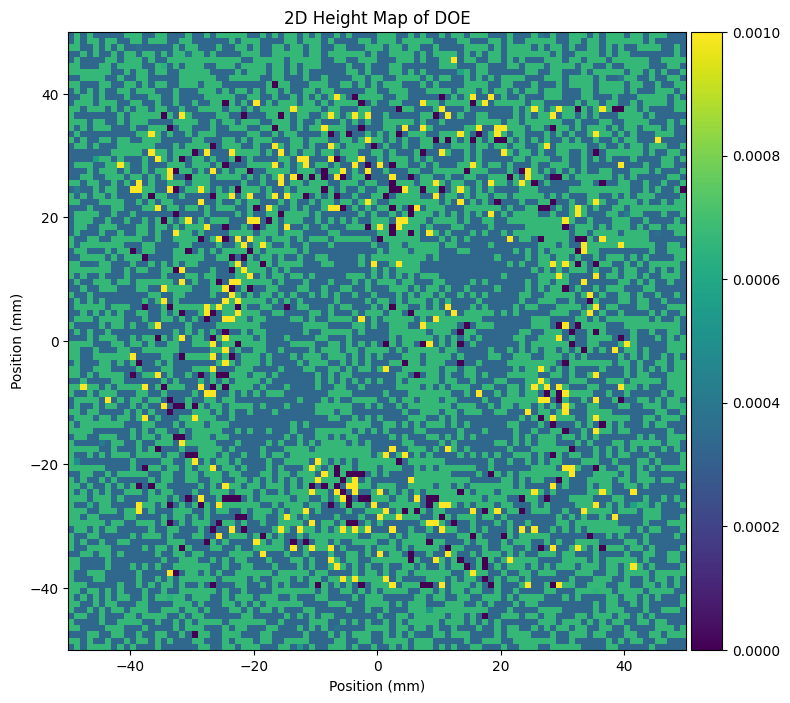

In [45]:
setup.doe.visualize(figsize=(8,8))

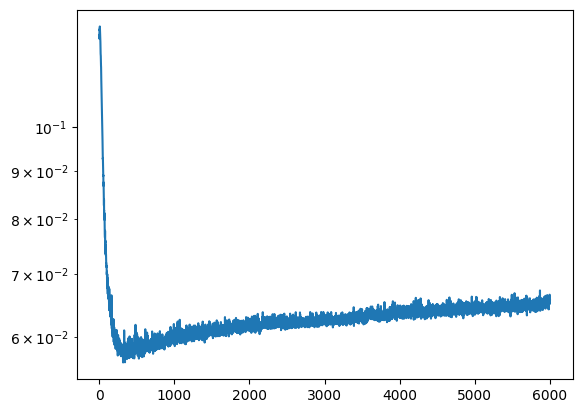

In [46]:
np.save('loss_curve_PSQ.npy', losses)
plt.plot(losses)
plt.yscale('log')

# 6. System with STEQuantizedDOELayer 

In [51]:
class Submm_Setupv2(nn.Module):
    """ simulate a simple system with one diffractive optical element 
        (Original Gumbel Quantized method with annealing factor)
    """
    def __init__(self, 
                 input_dxy, 
                 input_field_shape,
                 doe_params, 
                 optim_params,
                 wavelengths):
        super().__init__()
        
        self.input_dxy = input_dxy
        self.input_field_shape = input_field_shape
        self.doe_params = doe_params
        self.optim_params = optim_params
        
        self.wavelengths = wavelengths

        # Here we use the fit funtion of BeamWaistCorruagtedTK 
        self.source = self.source = Guassian_beam(height=self.input_field_shape[0], width=self.input_field_shape[1], 
                                    beam_waist_x=None,
                                    beam_waist_y=None,
                                    wavelengths=self.wavelengths, 
                                    spacing=self.input_dxy)
        
        self.asm_prop1 = ASM_prop(z_distance=0.127 * m, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        
        self.Colli_lens = Thin_LensElement(focal_length=0.127 * m)
        
        self.asm_prop2 = ASM_prop(z_distance=0.127 * m, 
                            bandlimit_type='exact', 
                            padding_scale=2, 
                            bandlimit_kernel=True)
        
        self.aperture = ApertureElement(aperture_type = 'rect',
                                   aperture_size = 0.08)
        
        self.input_field = self.field_before_DOE()

        self.doe = STEQuantizedDOELayer(self.doe_params, self.optim_params)
        

        self.asm_prop3 = ASM_prop(z_distance=100 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        self.asm_prop4 = ASM_prop(z_distance=150 * mm, 
                         bandlimit_type='exact', 
                         padding_scale=2, 
                         bandlimit_kernel=True)
        
        

    def field_before_DOE(self):
        field = self.source()
        field = self.asm_prop1(field)
        field = self.Colli_lens(field)
        field = self.asm_prop2(field)
        field = self.aperture(field)
        
        return field
    
    def forward(self, iter_frac):
        
        field = self.doe(self.input_field, iter_frac)
        
        final_field1 = self.asm_prop3(field)
        final_field2 = self.asm_prop4(field)
        
        return [final_field1, final_field2]

In [52]:
setup = Submm_Setupv2(input_dxy=input_dxy, 
                   input_field_shape=input_field_shape, 
                   doe_params=doe_params, 
                   optim_params=optim_params,
                   wavelengths=wavelengths)

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !


In [53]:
max_itrs = 6000 * 5

losses = []
itr_list = []
itr_to_save_plots = []
setup.cuda()
target1 = target1.cuda()
target2 = target2.cuda()
optimizer = torch.optim.AdamW(setup.parameters(), lr=0.01)

photometric_loss_fn = nn.MSELoss()

best_loss = 10

for itr in range(max_itrs):
    field_list = setup.forward(iter_frac=itr/max_itrs)
    out_field_1 = field_list[0]
    out_field_2 = field_list[1]
    out_amp_1 = normalize(torch.abs(out_field_1.data)**2)
    out_amp_2 = normalize(torch.abs(out_field_2.data)**2)
    loss = photometric_loss_fn(out_amp_1, target1) + photometric_loss_fn(out_amp_2, target2)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #grad = setup.hologram.weight_height_map.grad
    #print(grad)

    losses.append(loss.item())
    itr_list.append(itr)
    
    if itr % 2000 == 0 or itr == (max_itrs-1):
        print("The iteration : {}, Loss: {}".format(itr, loss))
        #out_field_1.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
        #out_field_2.visualize(flag_axis = True, figsize=(6,6), wavelength=wavelengths, intensity=True)
    
    if loss < best_loss:
        best_loss = loss
        best_field1 = out_field_1
        best_field2 = out_field_2

The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The critical distance is [0.26003873] m, the TF will be fine during the sampling !
The iteration : 0, Loss: 0.13212446868419647
The iteration : 2000, Loss: 0.045518115162849426
The iteration : 4000, Loss: 0.04889708757400513
The iteration : 6000, Loss: 0.04393380135297775
The iteration : 8000, Loss: 0.04348365589976311
The iteration : 10000, Loss: 0.04189923778176308
The iteration : 12000, Loss: 0.04785315692424774
The iteration : 14000, Loss: 0.04497663676738739
The iteration : 16000, Loss: 0.04304156452417374
The iteration : 18000, Loss: 0.04326144605875015
The iteration : 20000, Loss: 0.04306267946958542
The iteration : 22000, Loss: 0.041098710149526596
The iteration : 24000, Loss: 0.03915136307477951
The iteration : 26000, Loss: 0.03929398953914642
The iteration : 28000, Loss: 0.04448649287223816
The iteration : 29999, Loss: 0.0434672087430954


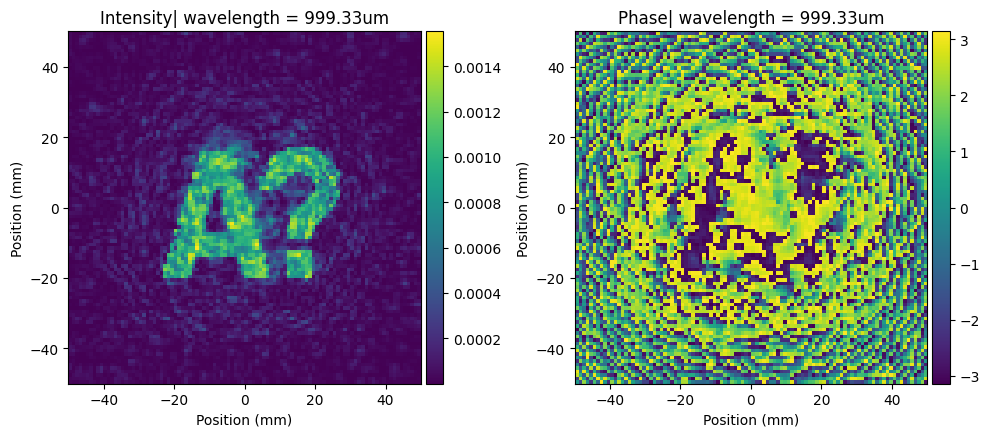

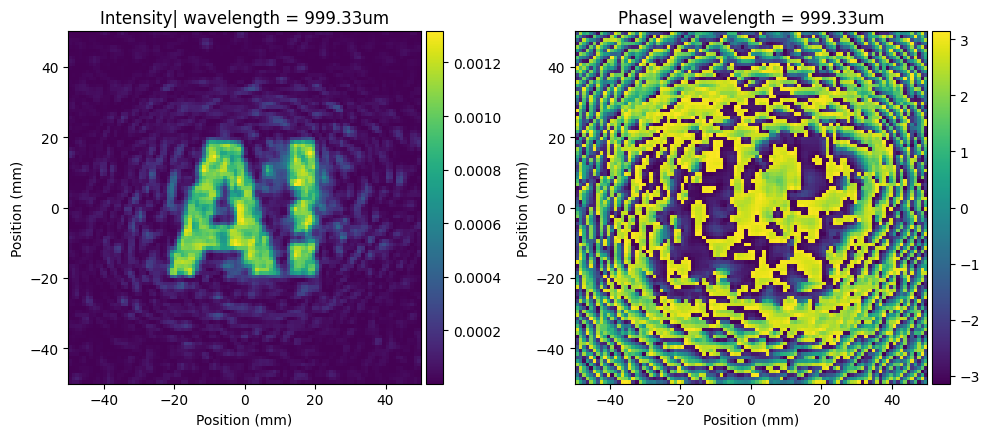

In [54]:
best_field1.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)
best_field2.visualize(flag_axis = True, figsize=(10,10), wavelength=wavelengths, intensity=True)

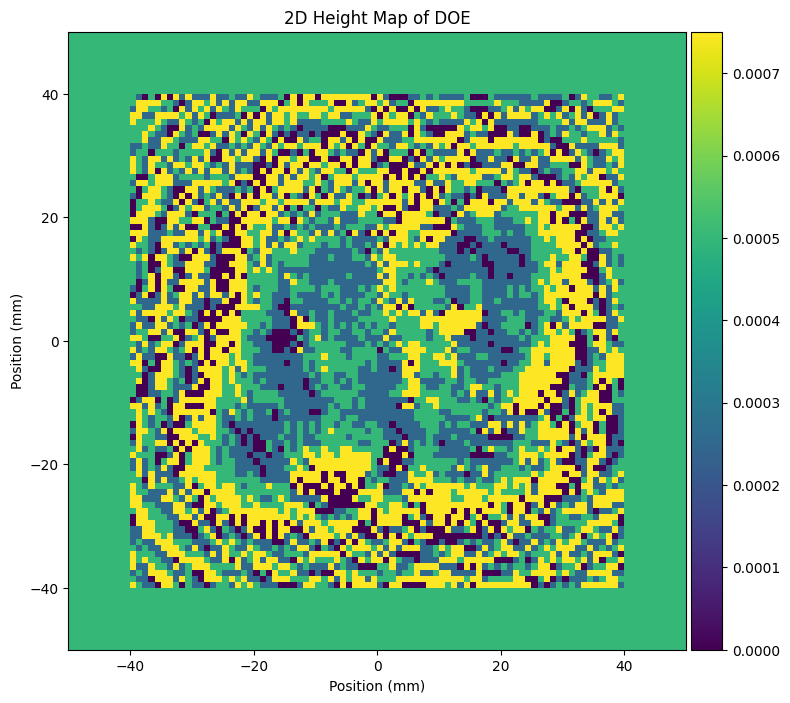

In [55]:
setup.doe.visualize(figsize=(8,8))

In [56]:
setup.doe.height_map.unique()

tensor([0.0000, 0.0003, 0.0005, 0.0008], device='cuda:0',
       grad_fn=<Unique2Backward0>)

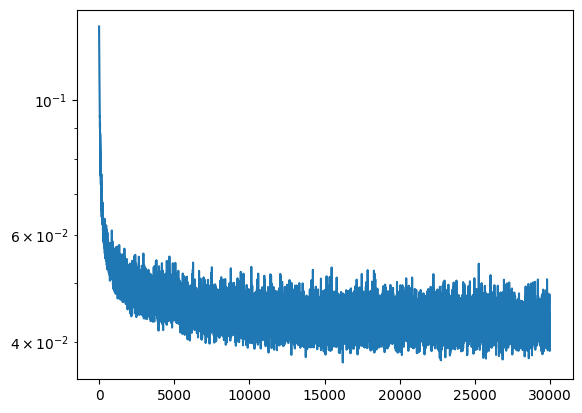

In [57]:
np.save('loss_curve_STE_more_iteration.npy', losses)
plt.plot(losses)
plt.yscale('log')

## 1. Visualize for 1D distribution False

In [8]:
#out_amp = normalize(torch.abs(out_field.data)**2)

In [61]:
# 1D distribution for spot 1 and 2
from utils.Visualization_Helper import float_to_unit_identifier, add_colorbar
"""
size_x = np.array(1 * mm * 200 / 2)
unit_val, unit_axis = float_to_unit_identifier(size_x)
size_x = size_x / unit_val

plt.figure(figsize=(12, 3))
plt.subplot(1, 2, 1)
x_axis_spot_1_2 = out_amp[0, 0, :, 50]
x_axis_spot_1_2 = x_axis_spot_1_2.detach().numpy()
new_x_axis = np.linspace(-size_x, size_x, len(x_axis_spot_1_2))
plt.plot(new_x_axis, x_axis_spot_1_2)
plt.ylim([0,1])
plt.xlim([-size_x, size_x])
plt.xlabel("Position (" + unit_axis + ")")

plt.subplot(1, 2, 2)
x_axis_spot_3_4 = out_amp[0, 0, :, 150]
x_axis_spot_3_4 = x_axis_spot_3_4.detach().numpy()
plt.plot(new_x_axis, x_axis_spot_3_4)
plt.ylim([0,1])
plt.xlim([-size_x, size_x])
plt.xlabel("Position (" + unit_axis + ")")
plt.tight_layout()
"""

'\nsize_x = np.array(1 * mm * 200 / 2)\nunit_val, unit_axis = float_to_unit_identifier(size_x)\nsize_x = size_x / unit_val\n\nplt.figure(figsize=(12, 3))\nplt.subplot(1, 2, 1)\nx_axis_spot_1_2 = out_amp[0, 0, :, 50]\nx_axis_spot_1_2 = x_axis_spot_1_2.detach().numpy()\nnew_x_axis = np.linspace(-size_x, size_x, len(x_axis_spot_1_2))\nplt.plot(new_x_axis, x_axis_spot_1_2)\nplt.ylim([0,1])\nplt.xlim([-size_x, size_x])\nplt.xlabel("Position (" + unit_axis + ")")\n\nplt.subplot(1, 2, 2)\nx_axis_spot_3_4 = out_amp[0, 0, :, 150]\nx_axis_spot_3_4 = x_axis_spot_3_4.detach().numpy()\nplt.plot(new_x_axis, x_axis_spot_3_4)\nplt.ylim([0,1])\nplt.xlim([-size_x, size_x])\nplt.xlabel("Position (" + unit_axis + ")")\nplt.tight_layout()\n'

## 2. Visualize for 2D quantized phase map of DOE

In [62]:
setup.hologram.q_phase.unique() - 2 * torch.pi

tensor([-3.1416, -2.3562, -1.5708, -0.7854,  0.0000,  0.7854,  1.5708,  2.3562],
       device='cuda:0', grad_fn=<SubBackward0>)

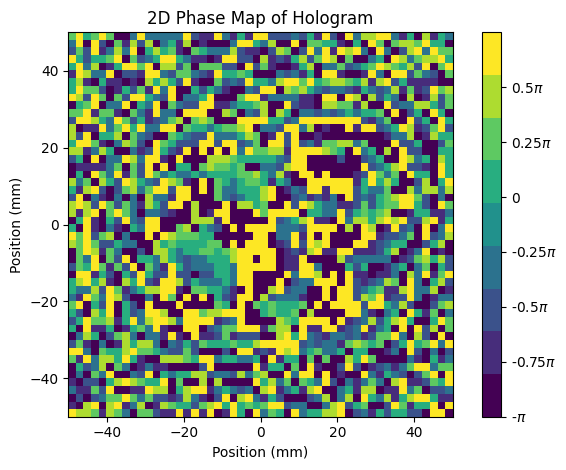

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors

size_x = np.array(1 * mm * 100 / 2)
unit_val, unit_axis = float_to_unit_identifier(size_x)
size_x = size_x / unit_val

extent = [-size_x, size_x, -size_x, size_x]

phase_map = setup.hologram.q_phase - 2 * torch.pi # 100 x 100
upsample_phase_map = nn.functional.interpolate(phase_map, size=[50, 50], mode='nearest')
#aperture = setup.hologram.Mask # 200 x 200
phase_map = upsample_phase_map #* aperture
phase_map = phase_map.squeeze(0,1).detach().cpu().numpy()

cmap = plt.get_cmap('viridis', 9)

fig, ax = plt.subplots()

cax = ax.imshow(phase_map, extent=extent, cmap=cmap)
ax.set_title('2D Phase Map of Hologram')
ax.set_xlabel("Position (" + unit_axis + ")")
ax.set_ylabel("Position (" + unit_axis + ")")

# Add a discrete colorbar with fractional π labels
ticks = np.linspace(-np.pi, np.pi, 9)  # Positions for the ticks
ticks = ticks[:-1]
tick_labels = ['-$\pi$', '-0.75$\pi$', '-0.5$\pi$', '-0.25$\pi$', '0', '0.25$\pi$', '0.5$\pi$', '0.75$\pi$']  # LaTeX formatted labels
cbar = fig.colorbar(cax, ticks=ticks)
cbar.ax.set_yticklabels(tick_labels)  # Set custom tick labels

plt.tight_layout()
plt.show()


array([-1.        , -0.75      , -0.50000006, -0.24999994,  0.        ,
        0.24999994,  0.50000006,  0.7499998 ], dtype=float32)